# Using Orion for Taxi Data


In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# signal from orion library that you can replace with your own data
from orion.data import load_signal
from mlblocks import add_pipelines_path, add_primitives_path
import logging

import matplotlib.pyplot as plt

import numpy as np

import pandas

import pandas as pd
import tensorflow as tf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler


In [6]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

np.random.seed(0)

def unroll_ts(y_hat):
    predictions = list()
    pred_length = y_hat.shape[1]
    num_errors = y_hat.shape[1] + (y_hat.shape[0] - 1)

    for i in range(num_errors):
            intermediate = []

            for j in range(max(0, i - num_errors + pred_length), min(i + 1, pred_length)):
                intermediate.append(y_hat[i - j, j])

            if intermediate:
                predictions.append(np.median(np.asarray(intermediate)))

    return np.asarray(predictions[pred_length-1:])

def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

def convert_date_single(x):
    return datetime.fromtimestamp(x)

def plot_ts(X, labels=None):
    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)
    
    if not isinstance(X, list):
        X = [X]
  
    for x in X:
        t = range(len(x))
        plt.plot(t, x)
    
    plt.title('NYC Taxi Demand', size=34)
    plt.ylabel('# passengers', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([t[0], t[-1]])
    
    if labels:
        plt.legend(labels=labels, loc=1, prop={'size': 26})
    
    plt.show()

def plot_error(X):
    plt.figure(figsize = (30, 6))
    gs1 = gridspec.GridSpec(3, 1)
    gs1.update(wspace=0.025, hspace=0.05) 

    i = 0
    for x in X:
        if len(x) == 2:
            ax1 = plt.subplot(gs1[i:i+2])
            for line in x:
                t = range(len(line))
                ax1.plot(t, line)
            i+=1
        else:
            ax1 = plt.subplot(gs1[i])
            t = range(len(line))
            ax1.plot(t, x, color='tab:red')

        i+=1
        plt.xlim(t[0], t[-1])
        plt.yticks(size=22)
        plt.axis('on')
        ax1.set_xticklabels([])

    plt.show()


def plot(dfs, anomalies=[]):
    """ Line plot for time series.
    
    This function plots time series and highlights anomalous regions.
    The first anomaly in anomalies is considered the ground truth.
    
    Args:
        dfs (list or `pd.DataFrame`): List of time series in `pd.DataFrame`.
            Or a single dataframe. All dataframes must have the same shape.
        anomalies (list): List of anomalies in tuple format.
    """    
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
        
    if not isinstance(anomalies, list):
        anomalies = [anomalies]
        
    df = dfs[0]
    time = convert_date(df['timestamp'])
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator() # every day

    month_fmt = mdates.DateFormatter('%b')

    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)

    for df in dfs:
        plt.plot(time, df['value'])

    colors = ['red'] + ['green'] * (len(anomalies) - 1)
    for i, anomaly in enumerate(anomalies):
        if not isinstance(anomaly, list):
            anomaly = list(anomaly[['start', 'end']].itertuples(index=False))
        
        for _, anom in enumerate(anomaly):
            t1 = convert_date_single(anom[0])
            t2 = convert_date_single(anom[1])
            plt.axvspan(t1, t2, color=colors[i], alpha=0.2)

    plt.title('NYC Taxi Demand', size=34)
    plt.ylabel('# passengers', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([time[0], time[-1]])

    # format xticks
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    ax.xaxis.set_minor_locator(days)
    
    # format yticks
    ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
    ax.set_yticklabels(ylabels)
    
    plt.show()
    
    
def plot_rws(X, window=100, k=5, lim=1000):
    shift = 75
    X = X[window:]
    t = range(len(X))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    
    num_figs = int(np.ceil(k / 5)) + 1
    fig = plt.figure(figsize=(15, num_figs * 2))
    
    j = 0
    ax = fig.add_subplot(num_figs, 5, j+1)
    idx = t[j: window + j]
    ax.plot(idx, X[j], lw=2, color=colors[j])
    plt.title("window %d" % j, size=16)
    plt.ylim([-1, 1])
    
    j = 1
    ax = fig.add_subplot(num_figs, 5, j+1)
    idx = t[j: window + j]
    ax.plot(idx, X[j], lw=2, color=colors[j])
    ax.set_yticklabels([])
    plt.title("window %d" % j, size=16)
    plt.ylim([-1, 1])
        
    for i in range(2, k):
        j = i * shift
        idx = t[j: window + j]
        
        ax = fig.add_subplot(num_figs, 5, i+1)
        ax.plot(idx, X[j], lw=2, color=colors[i+1])
        ax.set_yticklabels([])
        plt.title("window %d" % j, size=16)
        plt.ylim([-1, 1])
    
    plt.tight_layout()
    plt.show()

In [7]:
from orion.data import load_signal, load_anomalies

# load taxi data
df = load_signal('nyc_taxi')

# load ground truth anomalies
known_anomalies = load_anomalies('nyc_taxi')

df.head(5)

,timestamp,value
0,1404165600,10844.0
1,1404167400,8127.0
2,1404169200,6210.0
3,1404171000,4656.0
4,1404172800,3820.0


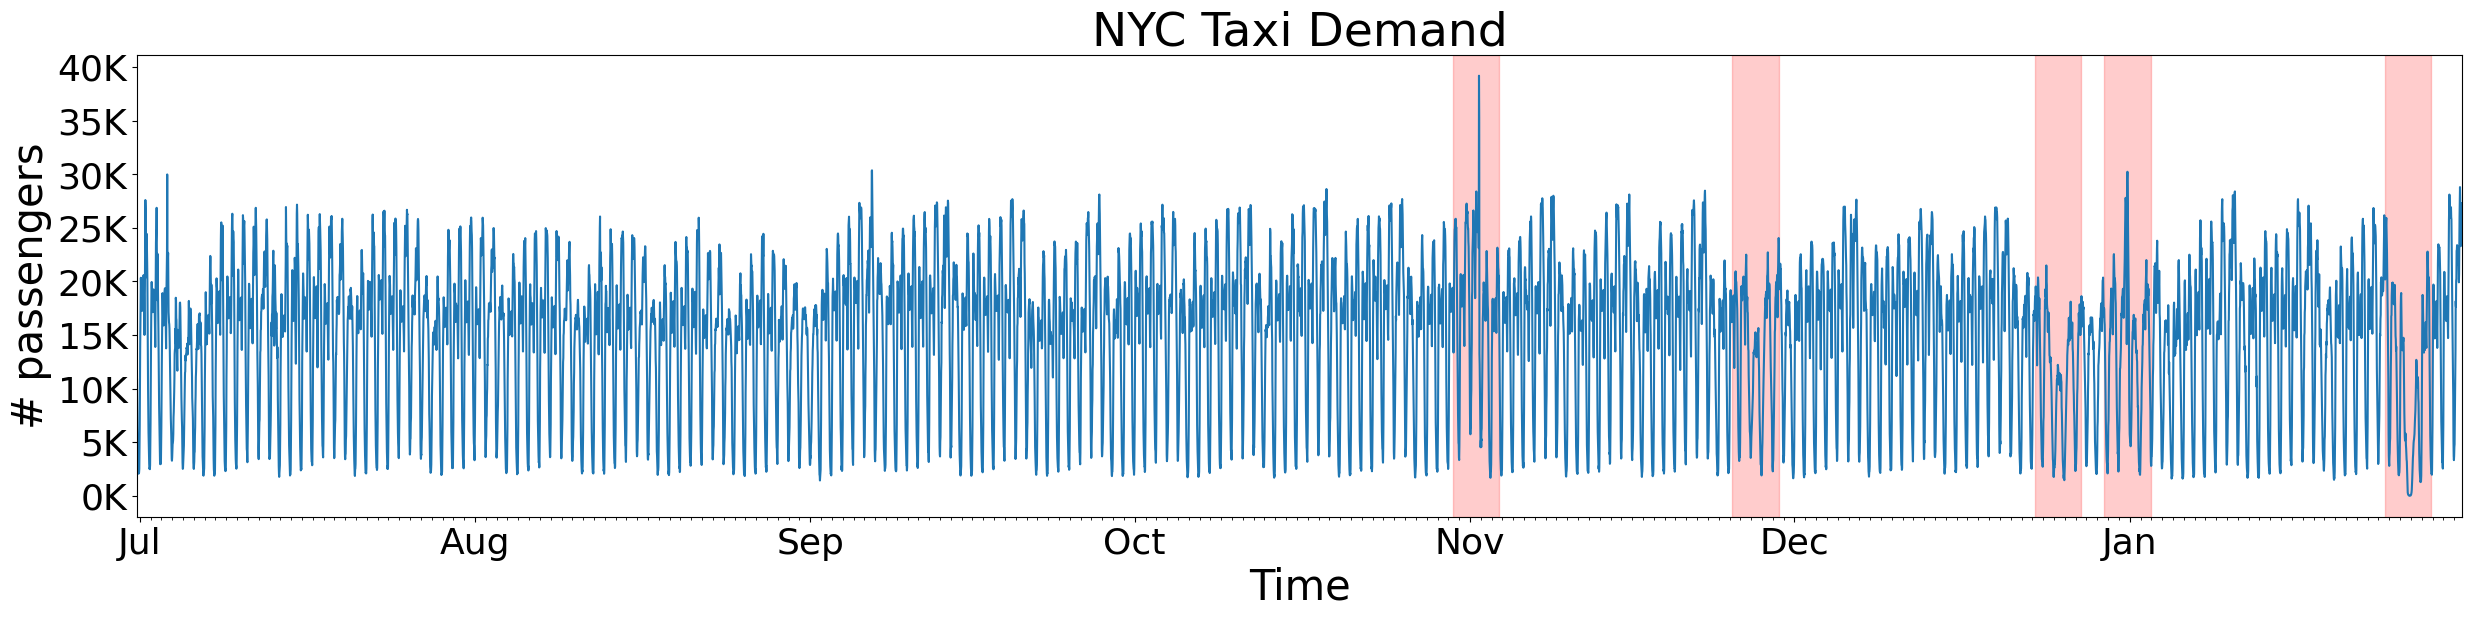

In [8]:
plot(df, known_anomalies)

In [9]:
# You can use a previously trained and serialized Orion model for anomaly detection.
# from orion import Orion
# orion = Orion.load('orion_pretrained.pkl')
# anomalies = orion.detect(df)

Epoch 1/5
10/10 [==============================] - 3s 93ms/step - loss: 0.2041 - tf.__operators__.getitem_9_loss: 0.2070 - tf.__operators__.getitem_10_loss: 0.2047 - tf.__operators__.getitem_11_loss: 0.1997 - val_loss: 0.2004 - val_tf.__operators__.getitem_9_loss: 0.1767 - val_tf.__operators__.getitem_10_loss: 0.2038 - val_tf.__operators__.getitem_11_loss: 0.2173
Epoch 2/5
10/10 [==============================] - 0s 36ms/step - loss: 0.1948 - tf.__operators__.getitem_9_loss: 0.1978 - tf.__operators__.getitem_10_loss: 0.1949 - tf.__operators__.getitem_11_loss: 0.1915 - val_loss: 0.1948 - val_tf.__operators__.getitem_9_loss: 0.1739 - val_tf.__operators__.getitem_10_loss: 0.1968 - val_tf.__operators__.getitem_11_loss: 0.2119
Epoch 3/5
10/10 [==============================] - 0s 36ms/step - loss: 0.1921 - tf.__operators__.getitem_9_loss: 0.1917 - tf.__operators__.getitem_10_loss: 0.1963 - tf.__operators__.getitem_11_loss: 0.1843 - val_loss: 0.2007 - val_tf.__operators__.getitem_9_loss: 0.1

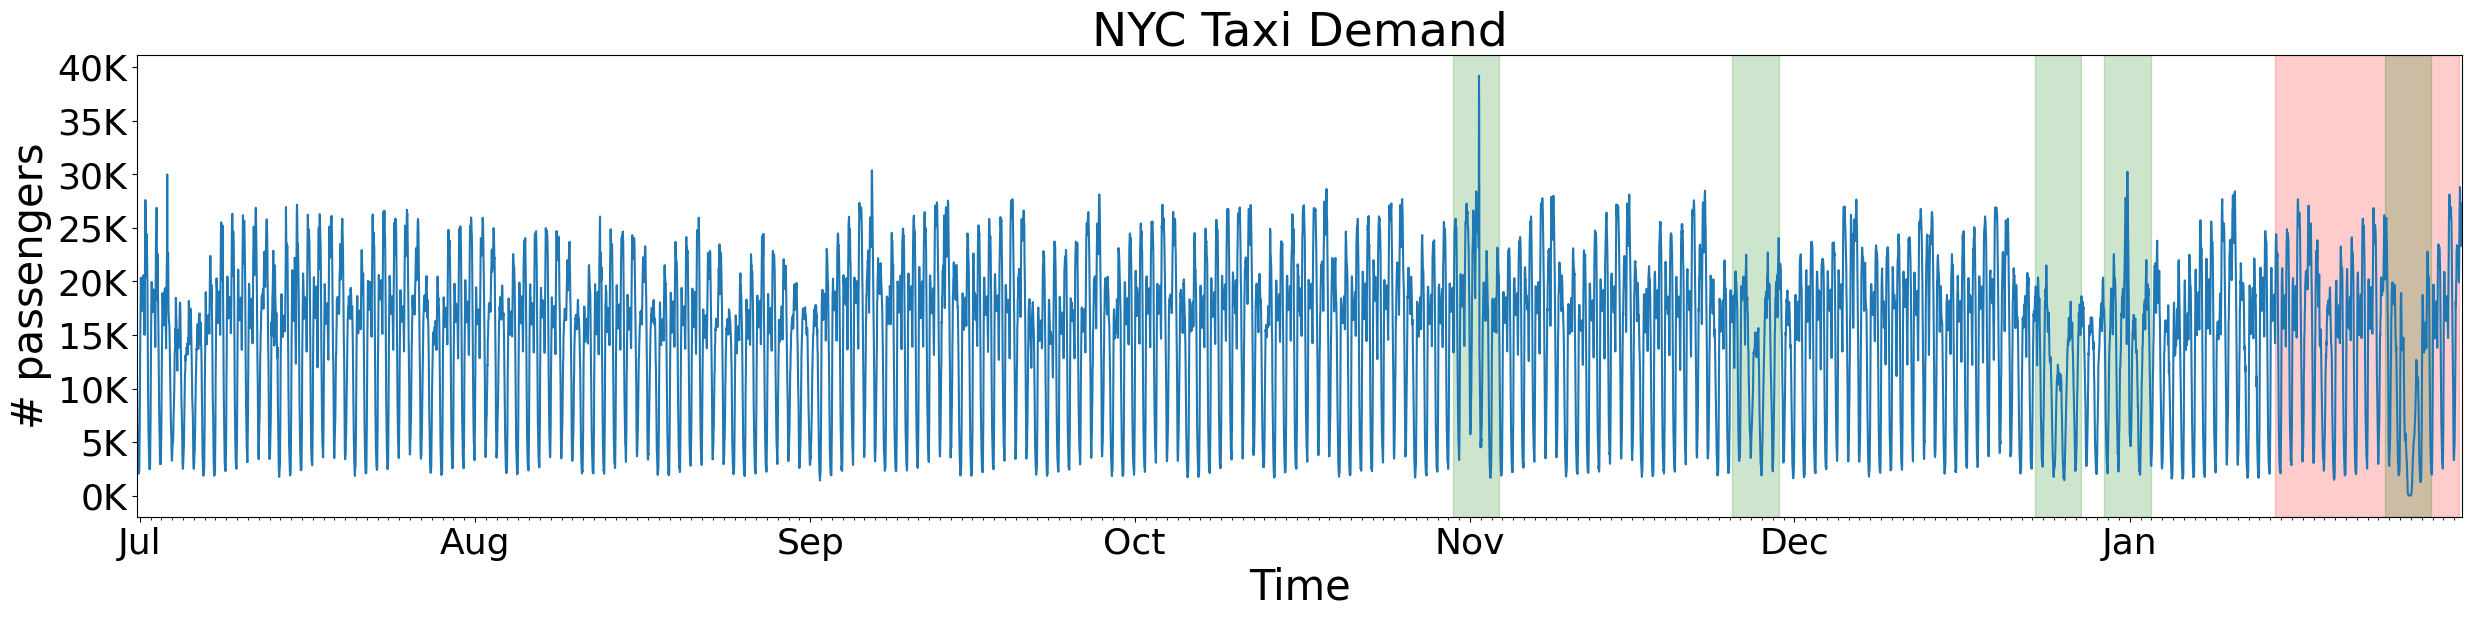

,start,end,severity
0,1421251200,1422720000,0.150986


In [23]:
from orion import Orion

hyperparameters = { # alter the hyperparameter settings here
    'mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1': {
        'interval': 21600
    },
    'orion.primitives.aer.AER#1': {
        'epochs': 5,
        'verbose': True
    }
}

orion = Orion(
    pipeline='aer',
    hyperparameters=hyperparameters
)

anomalies = orion.fit_detect(df)
plot(df, [anomalies, known_anomalies])
anomalies.head(5)

Epoch: 1/5, Losses: {'cx_loss': 6.6889, 'cz_loss': 1.8681, 'eg_loss': 2.0963}
Epoch: 2/5, Losses: {'cx_loss': 0.0522, 'cz_loss': 1.5459, 'eg_loss': 1.4501}
Epoch: 3/5, Losses: {'cx_loss': -2.4157, 'cz_loss': 1.7102, 'eg_loss': 0.4926}
Epoch: 4/5, Losses: {'cx_loss': -3.5249, 'cz_loss': 2.6242, 'eg_loss': -0.6581}
Epoch: 5/5, Losses: {'cx_loss': -3.8428, 'cz_loss': 4.0691, 'eg_loss': -1.9401}
24/24 [==============================] - 0s 3ms/step


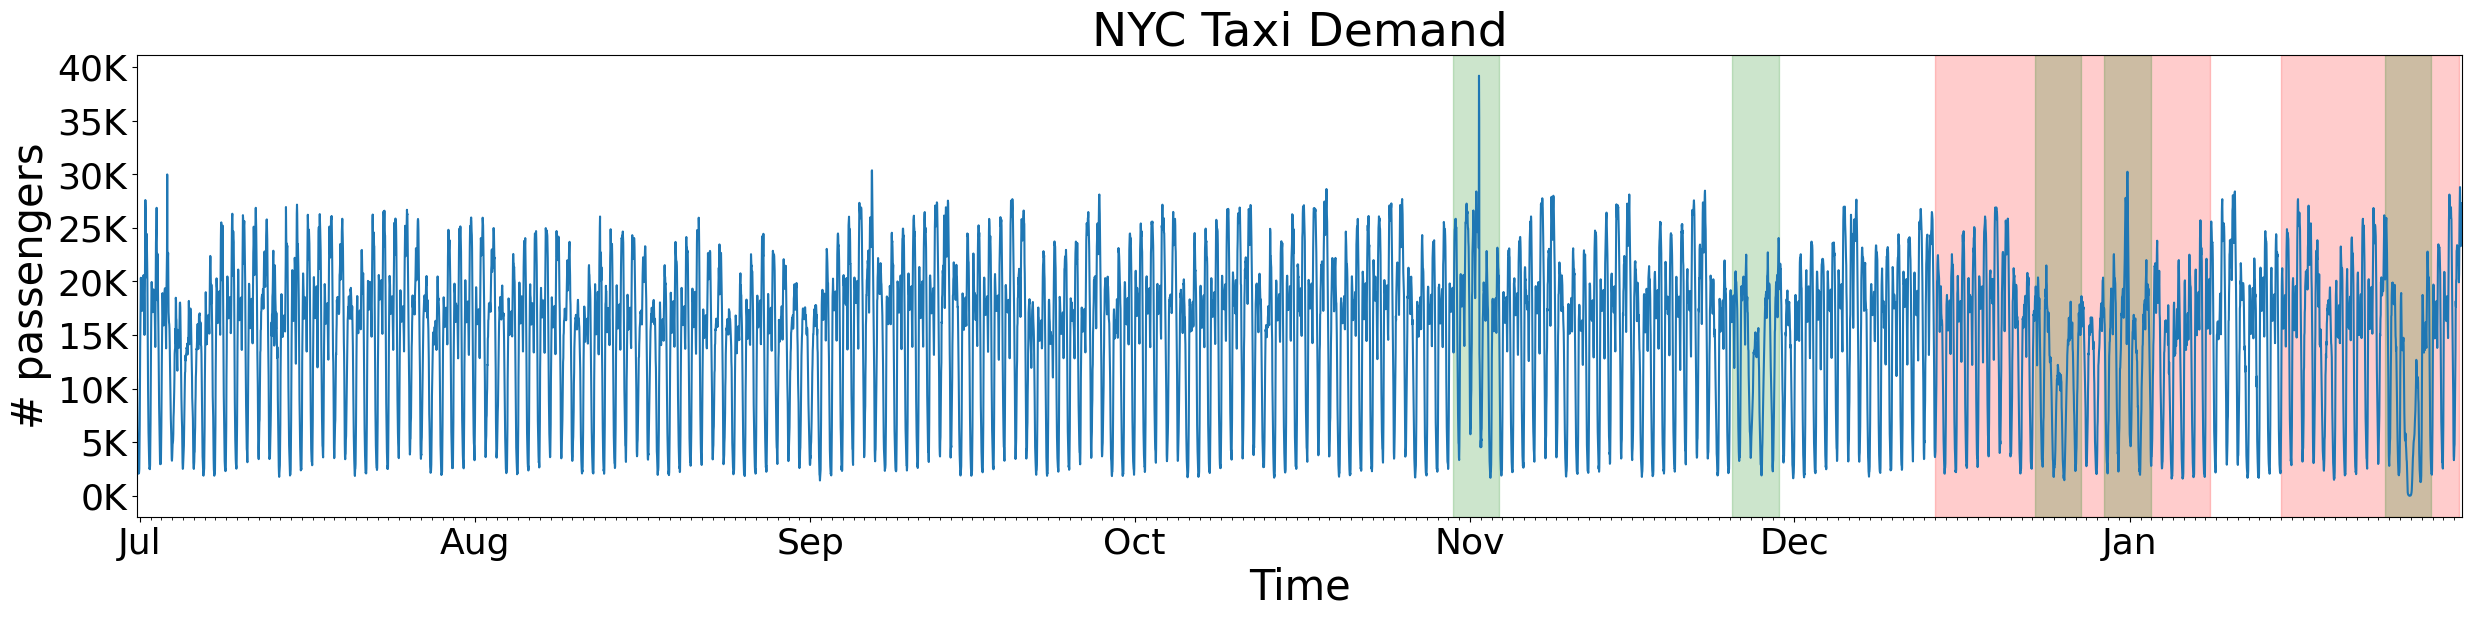

,start,end,severity
0,1418529600,1420732800,0.194502
1,1421294400,1422720000,0.267936


In [25]:
from orion import Orion

hyperparameters = {
    'sklearn.preprocessing.MinMaxScaler#1': {
        'feature_range': (-1, 1)
    }
}

orion = Orion(
    pipeline='.json',
    hyperparameters=hyperparameters
)

anomalies = orion.fit_detect(df)
plot(df, [anomalies, known_anomalies])
anomalies.head(5)

The taxi data spans 7 months between 2014 and 2015. The groun truth data (in green) shows five anomalies: NYC Marathon, Thanksgiving, Christmas, New Year’s Eve, and a major snow storm.

The model used above only detected three of the five anomalies.

In [2]:
from sigllm import SigLLM

hyperparameters = {
    "orion.primitives.timeseries_anomalies.find_anomalies#1": {
        "fixed_threshold": False
    }
}

sigllm = SigLLM(
    pipeline='gpt_detector',
    decimal=0,
    hyperparameters=hyperparameters
)

anomalies = sigllm.detect(df)

Exception caught building MLBlock sigllm.primitives.forecasting.gpt.GPT
Traceback (most recent call last):
  File "/Users/john/code/my/anomaly_detection/venv/lib/python3.11/site-packages/mlblocks/mlpipeline.py", line 119, in _build_blocks
    block = MLBlock(primitive, **block_params)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/john/code/my/anomaly_detection/venv/lib/python3.11/site-packages/mlblocks/mlblock.py", line 199, in __init__
    self.set_hyperparameters(default)
  File "/Users/john/code/my/anomaly_detection/venv/lib/python3.11/site-packages/mlblocks/mlblock.py", line 247, in set_hyperparameters
    self.instance = self.primitive(**self.get_hyperparameters())
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/john/code/my/anomaly_detection/venv/lib/python3.11/site-packages/sigllm/primitives/forecasting/gpt.py", line 86, in __init__
    self.client = OpenAI()
                  ^^^^^^^^
  File "/Users/john/code/my/anomaly_detection/

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable